In [1]:
#Load libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
#Transforms
transformer=transforms.Compose([
    transforms.Resize((300,300)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    torchvision.transforms.Grayscale(num_output_channels=1)
])

#dataloader
train_path =  r"C:\Datasets\Train_set"
test_path = r"C:\Datasets\Test_set"
train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=64, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=32, shuffle=True
)
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

cuda
['stage1', 'stage2', 'stage3', 'stage4', 'stage5', 'stage6', 'stage7', 'stage8', 'stage9']


In [5]:
#CNN Network


class ConvNet(nn.Module):
    def __init__(self,num_classes):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #((w-f+2P)/s) +1
        
        #Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=1,out_channels=8,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=8)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)
        
        
        self.conv2=nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)
        
        
        
        self.conv3=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)
        
        self.conv4=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu4=nn.ReLU()
        #Shape= (256,20,75,75)
        
        self.conv5=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn5=nn.BatchNorm2d(num_features=128)
        #Shape= (256,32,75,75)
        self.relu5=nn.ReLU()
        #Shape= (256,32,75,75)
        
        self.fc=nn.Linear(in_features=150 * 150 * 128,out_features=num_classes)
        
        
        
        #Feed forwad function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
        
        output=self.conv4(output)
        output=self.relu4(output)
        
        output=self.conv5(output)
        output=self.bn5(output)
        output=self.relu5(output)
        
            
            #Above output will be in matrix form, with shape (256,32,75,75)
            
        output=output.view(-1,128*150*150)
            
            
        output=self.fc(output)
            
        return output
            

In [7]:
model=ConvNet(num_classes=9).to(device)
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))
print(train_count,test_count)

77626 23645


In [8]:
import torch
import shutil
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    f_path = checkpoint_path
    torch.save(state, f_path)
    if is_best:
        best_fpath = best_model_path
        shutil.copyfile(f_path, best_fpath)

In [9]:
y_pred = []
y_true = []
train_losses = []
test_accuracies = []
best_accuracy= 0.0
test_accuracy=0.0
train_accuracy=0.0
train_loss=0.0

In [10]:
def train_test(start_epochs, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred):
    #Model training and saving best model

    for epoch in range(start_epochs, num_epochs+1):

        #Evaluation and training on training dataset
        model.train()

        for i, (images,labels) in enumerate(train_loader):
            if torch.cuda.is_available():
                images=Variable(images.cuda())
                labels=Variable(labels.cuda())

            optimizer.zero_grad()

            outputs=model(images)
            loss=loss_function(outputs,labels)
            loss.backward()
            optimizer.step()

            train_loss+= loss.cpu().data*images.size(0)
            _,prediction=torch.max(outputs.data,1)

            train_accuracy+=int(torch.sum(prediction==labels.data))

        train_accuracy=train_accuracy/train_count
        train_loss=train_loss/train_count

        # Evaluation on testing dataset
        model.eval()

        for i, (images,labels) in enumerate(test_loader):
            if torch.cuda.is_available():
                images=Variable(images.cuda())
                labels=Variable(labels.cuda())

            outputs=model(images)
            _,prediction=torch.max(outputs.data,1)
            test_accuracy+=int(torch.sum(prediction==labels.data))

            output = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction

            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

        test_accuracy=test_accuracy/test_count

        print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
        
        train_losses.append(train_loss.item())
        test_accuracies.append(test_accuracy)
        checkpoint = {
                'start_epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'best_accuracy': best_accuracy,
                'train_accuracy': train_accuracy,
                'test_accuracy': test_accuracy,
                'train_loss': train_loss,
                'train_losses':train_losses,
                'test_accuracies': test_accuracies,
                'y_true': y_true,
                'y_pred': y_pred
        }
        save_ckp(checkpoint, False, checkpoint_path='current_checkpoint_stagewise.pt', best_model_path='best_checkpoint_stagewise.model')
        #Save the best model
        if test_accuracy>best_accuracy:
            torch.save(model.state_dict(),'best_checkpoint_stagewise.model')
            best_accuracy=test_accuracy
            checkpoint['best_accuracy']=best_accuracy
            save_ckp(checkpoint, True, checkpoint_path='current_checkpoint_stagewise.pt', best_model_path='best_checkpoint_stagewise.model')

In [11]:
def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    best_accuracy = checkpoint['best_accuracy']
    train_accuracy = checkpoint['train_accuracy']
    test_accuracy = checkpoint['test_accuracy']
    train_loss = checkpoint['train_loss']    
    train_losses = checkpoint['train_losses']    
    test_accuracies = checkpoint['test_accuracies']   
    start_epoch = checkpoint['start_epoch']
    y_true = checkpoint['y_true']
    y_pred = checkpoint['y_pred']
    return model, optimizer,start_epoch,best_accuracy, train_accuracy,test_accuracy,train_loss.item(),train_losses,test_accuracies,y_true,y_pred

In [12]:
def conf_matrix(y_true,y_pred):
     # constant for classes
   # classes = ('L4', 'day1', 'day10', 'day11', 'day12', 'day13', 'day14', 'day15', 'day16', 'day17', 'day18', 'day19', 'day2', 'day20', 'day21', 'day3', 'day4', 'day5', 'day6', 'day7', 'day8', 'day9', 'others')

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix), index = [i for i in classes],
                         columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    plt.savefig('output.png')

In [13]:
def learn_curve_train_losses(train_losses):
    plt.plot(train_losses,'-o')
    plt.xlabel('epoch')
    plt.ylabel('losses')
    plt.legend(['Train'])
    plt.title('Train Losses Per Epoch')

    plt.show()
    
def learn_curve_test_accuracies(test_accuracies):
    plt.plot(test_accuracies,'-r')
    plt.xlabel('epoch')
    plt.ylabel('test_accuracy')
    plt.legend(['Test Accuracy'])
    plt.title('Test Accuracy Per Epoch')
    plt.show()


In [ ]:
num_epochs = 40

import os.path

if os.path.isfile("current_checkpoint_stagewise.pt"):
    ckp_path = "current_checkpoint_stagewise.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)


Epoch: 1 Train Loss: tensor(16.3814) Train Accuracy: 0.40166954370958186 Test Accuracy: 0.6013956438993445
Epoch: 2 Train Loss: tensor(0.6589) Train Accuracy: 0.7889161063244752 Test Accuracy: 0.6780546160136984
Epoch: 3 Train Loss: tensor(0.3988) Train Accuracy: 0.877280665190868 Test Accuracy: 0.6861356758137456
Epoch: 4 Train Loss: tensor(0.2909) Train Accuracy: 0.913081664399366 Test Accuracy: 0.7115959456830541
Epoch: 5 Train Loss: tensor(0.2410) Train Accuracy: 0.928837156128931 Test Accuracy: 0.6502732753624734
Epoch: 6 Train Loss: tensor(0.2165) Train Accuracy: 0.9362833179238416 Test Accuracy: 0.6915056152791441
Epoch: 7 Train Loss: tensor(0.1885) Train Accuracy: 0.9441158411269152 Test Accuracy: 0.7195048215527714
Epoch: 8 Train Loss: tensor(0.1751) Train Accuracy: 0.9479033328503481 Test Accuracy: 0.705168936554094
Epoch: 9 Train Loss: tensor(0.1571) Train Accuracy: 0.9535587033124578 Test Accuracy: 0.673491442966232
Epoch: 10 Train Loss: tensor(0.1396) Train Accuracy: 0.959

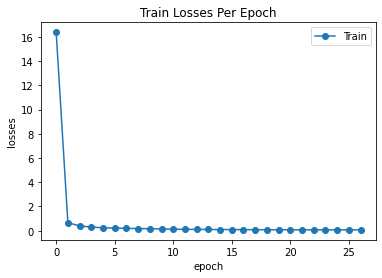

In [14]:
ckp_path = "current_checkpoint_stagewise.pt"
model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
learn_curve_train_losses(train_losses)

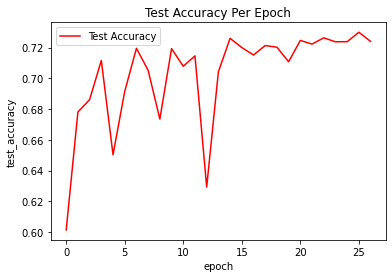

In [15]:
learn_curve_test_accuracies(test_accuracies)

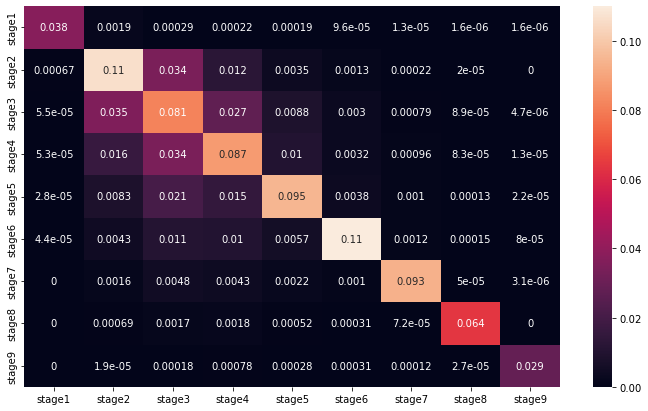

In [16]:
conf_matrix(y_true,y_pred)